<a href="https://colab.research.google.com/github/Kiira6/kiira6.github.io/blob/master/Perceiver_IO_%2B_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import fnmatch

def find_mp3_files(directory):
    # Lista para almacenar las rutas de los archivos .mp3
    mp3_files = []

    # Recorrer el directorio y subdirectorios
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            # Si el archivo es .mp3, agregarlo a la lista
            if fnmatch.fnmatch(filename, '*.mp3'):
                mp3_files.append(os.path.join(dirpath, filename))

    return mp3_files

def find_mp3_vocals(directory):
    # List to store the paths of the files
    mp3_files = []

    # Traverse the directory and its subdirectories
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            # If the file is "vocals.mp3", add it to the list
            if fnmatch.fnmatch(filename, 'vocals.mp3'):
                mp3_files.append(os.path.join(dirpath, filename))

    return mp3_files

def get_str_element(str, element, separator = '\\'):
    # Split the path by the directory separator
    elements = str.split(separator)

    # Return the third element
    return elements[element]

# Test the function
path = 'D:\\ProyectoLibertad\\mp3\\Burl Ives\\Cheers The Versatile Burl Ives!\\18 - Burl Ives - Royal Telephone.mp3'
print(get_str_element(path, 3))  # Outputs: Burl Ives


Burl Ives


In [5]:
# Solicitamos al usuario la ruta donde buscar los archivos mp3
mp3_directory = "D:\ProyectoLibertad\mp3"
mp3_files = find_mp3_files(mp3_directory)

len(mp3_files)

119355

In [56]:
import torch
from torch import nn
import torch.utils.checkpoint as checkpoint

class AudioPerceiverIO(nn.Module):
    def __init__(self):
        super(AudioPerceiverIO, self).__init__()

        # Especificar el tamaño de los embeddings
        self.embedding_dim = 512

        # Crear transformación MFCC
        self.mfcc = MFCC()

        # Inicializar el tokenizer
        #self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

        # Crear Perceiver IO
        self.perceiver_io = PerceiverIO(
            dim = 19846,                 # dimension of sequence to be encoded
            queries_dim = 512,           # dimension of decoder queries
            logits_dim = 100,            # dimension of final logits
            depth = 6,                   # depth of net
            num_latents = 2048,          # number of latents, or induced set points, or centroids. different papers giving it different names
            latent_dim = 124032,         # latent dimension
            cross_heads = 1,             # number of heads for cross attention. paper said 1
            latent_heads = 16,           # number of heads for latent self attention, 8
            cross_dim_head = 256,        # number of dimensions per cross attention head
            latent_dim_head = 64,        # number of dimensions per latent self attention head
            weight_tie_layers = False,   # whether to weight tie layers (optional, as indicated in the diagram)
            seq_dropout_prob = 0.2       # fraction of the tokens from the input sequence to dropout (structured dropout, for saving compute and regularizing effects)
        )

        #self.final_layer_1 = nn.Linear(512, 3969000)
        #self.final_layer_2 = nn.Linear(8192, 124032)
        #self.final_layer_3 = nn.Linear(8192, 32768)
        #self.final_layer_4 = nn.Linear(32768, 65536)
        #self.final_layer_5 = nn.Linear(65536, 124032)

        # Crear embeddings
        #self.audio_embedding = nn.Linear(22050, self.embedding_dim)
        #self.mfcc_embedding = nn.Linear(40, self.embedding_dim) # Suponiendo que MFCC genera 40 características
        #self.text_embedding = nn.Embedding(5000, self.embedding_dim)

    def forward(self, x):
        # Extraer la onda de sonido y las características MFCC
        #audio_waveform = x_audio
        #song_waveform = x_song if x_song is not None else None
        #audio_mfcc = self.mfcc(x_audio)
        #song_mfcc = self.mfcc(x_song) if x_song is not None else None

        # Tokenizar el texto
        #text_tokens = self.tokenizer(x_text, truncation=True, padding=True, return_tensors='pt')

        # Pasar a través de los embeddings
        #audio_waveform_embedded = self.audio_embedding(audio_waveform)
        #audio_mfcc_embedded = self.mfcc_embedding(audio_mfcc)
        #song_waveform_embedded = self.audio_embedding(song_waveform) if song_waveform is not None else None
        #song_mfcc_embedded = self.mfcc_embedding(song_mfcc) if song_waveform is not None else None
        #text_embedded = self.text_embedding(text_tokens['input_ids'])

        # Concatenar las salidas
        #inputs = [[1], [[[1]]]]#torch.cat([audio_waveform_embedded, audio_mfcc_embedded, song_waveform_embedded, song_mfcc_embedded, text_embedded], dim=-1)

        # Pasar a través del Perceiver IO
        output = checkpoint.checkpoint(self.perceiver_io, x)
        #output = checkpoint.checkpoint(self.final_layer_1, output)
        #output = self.final_layer_2(output)
        #output = self.final_layer_3(output)
        #output = self.final_layer_4(output)
        #output = self.final_layer_5(output)

        return output


In [57]:
import torch
import pytorch_lightning as pl
from torchaudio.transforms import MFCC
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from perceiver_pytorch import PerceiverIO
import torch.nn as nn
from torch.nn import functional as F

class AudioPerceiverIOModule(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.audio_perceiver_io = AudioPerceiverIO()

    def forward(self, x):
        return self.audio_perceiver_io(x)

    def training_step(self, batch, batch_idx):
        x_vocal_sinewave, x_output_sinewave = batch

        # MFCC transform
        mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=128).to(x_vocal_sinewave.device)
        x_vocal_mfcc = mfcc_transform(x_vocal_sinewave)
        x_output_mfcc = mfcc_transform(x_output_sinewave)

        # Log-Mel Spectrogram transform
        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=128).to(x_vocal_sinewave.device)
        log_mel_transform = torchaudio.transforms.AmplitudeToDB().to(x_vocal_sinewave.device)
        x_vocal_log_mel = log_mel_transform(mel_transform(x_vocal_sinewave))
        x_output_log_mel = log_mel_transform(mel_transform(x_output_sinewave))

        #autoencoder_module.eval()
        #y = autoencoder_module.encode(x_output_sinewave)
        #print("Y SHAPE:", y.shape)
        #print("X OUTPUT:", x_output_sinewave.shape)
        #ae_output_sinewave = autoencoder_module.decode(y)

        x_vocal_log_mel = x_vocal_log_mel.squeeze(0)
        #inputs = torch.cat([x_vocal_sinewave, x_vocal_log_mel], dim=-1)

        output_sinewave = self.audio_perceiver_io(x_vocal_log_mel)

        output_sinewave = output_sinewave[:, :, :22050*180]
        #ae_output_sinewave = ae_output_sinewave.squeeze(0)
        #ae_output_sinewave = ae_output_sinewave.detach()
        #ae_output_sinewave = ae_output_sinewave.sum(dim=0, keepdim=True)

        output_mfcc = mfcc_transform(output_sinewave)
        output_log_mel = log_mel_transform(mel_transform(output_sinewave))

        #tensor_loss = F.mse_loss(output, y)
        sinewave_loss = F.mse_loss(output_sinewave, x_output_sinewave)
        mfcc_loss = F.mse_loss(output_mfcc, x_output_mfcc)
        log_mel_loss = F.mse_loss(output_log_mel, x_output_log_mel)

        loss = sinewave_loss + mfcc_loss + log_mel_loss

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x_vocal_sinewave, x_output_sinewave = batch

        # MFCC transform
        mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=128).to(x_vocal_sinewave.device)
        x_vocal_mfcc = mfcc_transform(x_vocal_sinewave)
        x_output_mfcc = mfcc_transform(x_output_sinewave)

        # Log-Mel Spectrogram transform
        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=128).to(x_vocal_sinewave.device)
        log_mel_transform = torchaudio.transforms.AmplitudeToDB().to(x_vocal_sinewave.device)
        x_vocal_log_mel = log_mel_transform(mel_transform(x_vocal_sinewave))
        x_output_log_mel = log_mel_transform(mel_transform(x_output_sinewave))

        x_vocal_log_mel = x_vocal_log_mel.squeeze(0)
        #inputs = torch.cat([x_vocal_sinewave, x_vocal_log_mel], dim=-1)

        output_sinewave = self.audio_perceiver_io(x_vocal_log_mel)

        output_sinewave = output_sinewave[:, :, :22050*180]
        #ae_output_sinewave = ae_output_sinewave.squeeze(0)
        #ae_output_sinewave = ae_output_sinewave.detach()
        #ae_output_sinewave = ae_output_sinewave.sum(dim=0, keepdim=True)

        output_mfcc = mfcc_transform(output_sinewave)
        output_log_mel = log_mel_transform(mel_transform(output_sinewave))

        #tensor_loss = F.mse_loss(output, y)
        sinewave_loss = F.mse_loss(output_sinewave, x_output_sinewave)
        mfcc_loss = F.mse_loss(output_mfcc, x_output_mfcc)
        log_mel_loss = F.mse_loss(output_log_mel, x_output_log_mel)

        loss = sinewave_loss + mfcc_loss + log_mel_loss

        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4)

        # Define tu función de programación (scheduling)
        # Aquí, estoy usando una función que disminuye linealmente la tasa de aprendizaje hasta 0 a lo largo de las épocas.
        # Puedes ajustar esta función según tus necesidades.
        def lr_lambda(current_step):
            return max(0.0, float(self.trainer.max_steps - current_step) / float(max(1, self.trainer.max_steps)))

        scheduler = LambdaLR(optimizer, lr_lambda)

        return [optimizer], [scheduler]


In [ ]:
import sys
print(sys.path)
import sys
print(sys.executable)


['C:\\Users\\PC', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\python310.zip', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\DLLs', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\lib', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats', '', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\lib\\site-packages', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\lib\\site-packages\\win32', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\lib\\site-packages\\win32\\lib', 'C:\\Users\\PC\\anaconda3\\envs\\Bumblebeeats\\lib\\site-packages\\Pythonwin']
C:\Users\PC\anaconda3\envs\Bumblebeeats\python.exe


In [22]:
from torch.utils.data import Dataset
import os
import torchaudio
import torch.nn.functional as F

class AudioDataset(Dataset):
    def __init__(self, audio_paths, voice_max_length=22050*180, output_max_length=22050*180):
        self.file_list = audio_paths
        self.voice_max_length = voice_max_length
        self.output_max_length = output_max_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        out_path = self.file_list[idx]
        vocal_path = "C:\ProyectoLibertad\samples\{}".format(get_str_element(out_path, 3))
        vocals = find_mp3_vocals(vocal_path)
        vocal_path = random.sample(vocals, 1)[0]


        vocal_waveform, sample_rate = torchaudio.load(vocal_path)
        # Convert to mono by averaging the channels
        vocal_waveform = torch.mean(vocal_waveform, dim=0, keepdim=True)  # Convert to mono
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=22050)
        vocal_waveform = resampler(vocal_waveform)
        vocal_waveform = vocal_waveform[:, :self.voice_max_length]

        output_waveform, sample_rate = torchaudio.load(vocal_path)
        # Convert to mono by averaging the channels
        output_waveform = torch.mean(output_waveform, dim=0, keepdim=True)  # Convert to mono
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=22050)
        output_waveform = resampler(output_waveform)
        output_waveform = output_waveform[:, :self.voice_max_length]

        # Pad or truncate the waveform to a fixed length
        if vocal_waveform.size(1) < self.voice_max_length:
            padding = torch.zeros((vocal_waveform.size(0), self.voice_max_length - vocal_waveform.size(1)))
            vocal_waveform = torch.cat((vocal_waveform, padding), dim=1)

        # Pad or truncate the waveform to a fixed length
        if output_waveform.size(1) < self.output_max_length:
            padding = torch.zeros((output_waveform.size(0), self.output_max_length - output_waveform.size(1)))
            output_waveform = torch.cat((output_waveform, padding), dim=1)

        return vocal_waveform, output_waveform


In [54]:
import random
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

n = 10  # Número de elementos que quieres seleccionar
random_files = random.sample(mp3_files, n)

# Crear el conjunto de datos completo
dataset = AudioDataset(random_files)

# Determinar los tamaños de los conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # 20% para prueba

# Dividir el conjunto de datos
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crear los DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [10]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Define un ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    # Ruta donde se guardarán los checkpoints
    dirpath='C:\\ProyectoLibertad\\perceiver_io\\checkpoints',
    # Nombre del archivo del checkpoint
    filename='autoencoder-{epoch:02d}-{val_loss:.2f}',
    # Guarda un checkpoint cada X épocas
    every_n_epochs=1,
    # Guarda solo los K mejores modelos
    save_top_k=1000,
    # Métrica de validación para determinar cuáles son los mejores modelos
    monitor='val_loss',
    # Modo del monitor ('min' para pérdida, 'max' para precisión, etc.)
    mode='min',
)


In [58]:
import torch

# Antes de cargar el modelo
mem_before = torch.cuda.memory_allocated()

# Cargar el modelo en la GPU
model = AudioPerceiverIOModule()
model = model.to('cuda')

# Después de cargar el modelo
mem_after = torch.cuda.memory_allocated()

# Calcular la diferencia
mem_diff = mem_after - mem_before
print(f'El modelo utiliza aproximadamente {mem_diff} bytes de memoria en la GPU')


RuntimeError: ignored

In [55]:
from pytorch_lightning import Trainer

torch.set_float32_matmul_precision('medium')
torchaudio.set_audio_backend("soundfile")

#model = AudioPerceiverIOModule()
trainer = Trainer(max_epochs=1, callbacks=[checkpoint_callback])

# Pasar los dataloaders al método fit()
trainer.fit(model, train_dataloader, val_dataloaders=test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | audio_perceiver_io | AudioPerceiverIO | 2.1 B 
--------------------------------------------------------
2.1 B     Trainable params
0         Non-trainable params
2.1 B     Total params
8,244.771 Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|███████████████████████████                           | 1/2 [00:00<00:00, 10.00it/s]

C:\Users\PC\AppData\Local\Temp\ipykernel_5348\2786852414.py:90: UserWarning: Using a target size (torch.Size([1, 1, 3969000])) that is different to the input size (torch.Size([1, 128, 3969000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sinewave_loss = F.mse_loss(output_sinewave, x_output_sinewave)
C:\Users\PC\AppData\Local\Temp\ipykernel_5348\2786852414.py:91: UserWarning: Using a target size (torch.Size([1, 1, 128, 19846])) that is different to the input size (torch.Size([1, 128, 128, 19846])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mfcc_loss = F.mse_loss(output_mfcc, x_output_mfcc)
C:\Users\PC\AppData\Local\Temp\ipykernel_5348\2786852414.py:92: UserWarning: Using a target size (torch.Size([1, 1, 128, 19846])) that is different to the input size (torch.Size([1, 128, 128, 19846])). This will likely lead to incorrect results due to broadcasting. Please ensur

C:\Users\PC\anaconda3\envs\Bumblebeeats\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|                                                                                   | 0/8 [00:00<?, ?it/s]

C:\Users\PC\AppData\Local\Temp\ipykernel_5348\2786852414.py:53: UserWarning: Using a target size (torch.Size([1, 1, 3969000])) that is different to the input size (torch.Size([1, 128, 3969000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sinewave_loss = F.mse_loss(output_sinewave, x_output_sinewave)
C:\Users\PC\AppData\Local\Temp\ipykernel_5348\2786852414.py:54: UserWarning: Using a target size (torch.Size([1, 1, 128, 19846])) that is different to the input size (torch.Size([1, 128, 128, 19846])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mfcc_loss = F.mse_loss(output_mfcc, x_output_mfcc)
C:\Users\PC\AppData\Local\Temp\ipykernel_5348\2786852414.py:55: UserWarning: Using a target size (torch.Size([1, 1, 128, 19846])) that is different to the input size (torch.Size([1, 128, 128, 19846])). This will likely lead to incorrect results due to broadcasting. Please ensur

RuntimeError: ignored

In [ ]:
!pip install sox

In [ ]:
torchaudio.list_audio_backends()

['soundfile']

In [ ]:
train_dataset.__getitem__(0)

('D:\\ProyectoLibertad\\mp3\\I Draw Slow\\Turn Your Face to the Sun\\4 - I Draw Slow - Garage Flower.mp3',
 'C:\\ProyectoLibertad\\samples\\I Draw Slow\\vocals\\htdemucs\\0Yei88teo8fwnJN89hFFYe\\vocals.mp3',
 tensor([[ 5.3015e-13,  1.4508e-12, -1.5659e-12,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 tensor([[ 5.3015e-13,  1.4508e-12, -1.5659e-12,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]))

In [ ]:
apio = AudioPerceiverIO()

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [20]:
# Primero, debes crear una instancia del mismo tipo de modelo
autoencoder_module = AutoEncoderModule()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder_module = autoencoder_module.to(device)


# Luego, puedes cargar los parámetros del modelo
#model2.load_state_dict(torch.load('C:\\ProyectoLibertad\\autoencoder\\checkpoints\\autoencoder-epoch=09-val_loss=198.90.ckpt'))
checkpoint = torch.load('C:\\ProyectoLibertad\\autoencoder\\checkpoints\\autoencoder-epoch=02-val_loss=14.87.ckpt')
autoencoder_module.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [16]:
import torch
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # To ensure the output is in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Epoch 0:   0%|                                                                                 | 0/1 [4:01:43<?, ?it/s]


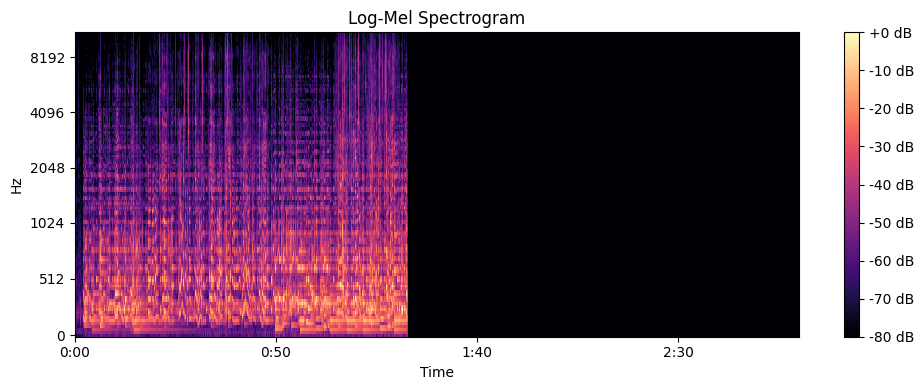

NameError: ignored

In [65]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os

def display_log_mel_spectrogram(mp3_path, sr=22050):
    # Convert MP3 to WAV
    #audio = AudioSegment.from_mp3(mp3_path)
    #wav_path = os.path.splitext(mp3_path)[0] + ".wav"
    #audio.export(wav_path, format="wav")

    # Load the audio file
    y, sr = librosa.load(mp3_path, sr=sr)

    # Calculate the log-mel spectrogram
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)

    # Display the log-mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_melspec, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Log-Mel Spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()
    plt.show()

    # Remove temporary wav file
    os.remove(wav_path)

# Test the function
display_log_mel_spectrogram('C:\\ProyectoLibertad\\autoencoder\\validations\\6.wav')


In [64]:
!pip install librosa

  Using cached librosa-0.10.0.post2-py3-none-any.whl (253 kB)
     --------------------------------------- 44.0/44.0 MB 43.7 MB/s eta 0:00:00
     ---------------------------------------- 184.0/184.0 kB ? eta 0:00:00
     ------------------------------------- 302.0/302.0 kB 19.4 MB/s eta 0:00:00
     ---------------------------------------- 61.6/61.6 kB ? eta 0:00:00
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
     ---------------------------------------- 9.2/9.2 MB 59.2 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 53.8 MB/s eta 0:00:00
  Using cached audioread-3.0.0.tar.gz (377 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 27.7/27.7 MB 32.8 MB/s eta 0:00:00
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl

In [17]:
import pytorch_lightning as pl
import torchaudio

class AutoEncoderModule(pl.LightningModule):
    def __init__(self):
        super(AutoEncoderModule, self).__init__()
        self.autoencoder = AutoEncoder()

    def forward(self, x):
        return self.autoencoder(x)

    def save_decoded_audio(self, decoded_waveform, sample_rate, filename):
        """
        Save the decoded waveform as an audio file.

        Args:
            decoded_waveform (torch.Tensor): The decoded waveform to save. Should be of shape (n_channels, n_time_steps).
            sample_rate (int): The sample rate for the audio file.
            filename (str): The name of the file to save the audio as.
        """

        mono_tensor = decoded_waveform.squeeze(0)
        mono_tensor = mono_tensor.detach()
        mono_tensor = mono_tensor.sum(dim=0, keepdim=True)
        torchaudio.save(filename, decoded_waveform[0], sample_rate)

    def training_step(self, batch, batch_idx):
        x = batch

        # MFCC transform
        mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=128).to(x.device)
        y_mfcc = mfcc_transform(x)

        # Autoencoder output
        z = self.autoencoder(x)
        z = z[:, :, :22050*180]
        z_mfcc = mfcc_transform(z)

        # Log-Mel Spectrogram transform
        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=40).to(x.device)
        log_mel_transform = torchaudio.transforms.AmplitudeToDB().to(x.device)
        y_log_mel = log_mel_transform(mel_transform(x))
        z_log_mel = log_mel_transform(mel_transform(z))

        # Loss calculation
        loss_mfcc = nn.MSELoss()(z_mfcc, y_mfcc)
        loss_waveform = nn.MSELoss()(z, x)
        #loss_log_mel = nn.MSELoss()(z_log_mel, y_log_mel)
        loss = loss_mfcc + loss_waveform # + loss_log_mel

        self.log('train_loss', loss)
        print('\ntrain_loss:', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch

        # MFCC transform
        mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=128).to(x.device)
        y_mfcc = mfcc_transform(x)

        # Autoencoder output
        z = self.autoencoder(x)
        z = z[:, :, :22050*180]
        z_mfcc = mfcc_transform(z)

        # Log-Mel Spectrogram transform
        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=40).to(x.device)
        log_mel_transform = torchaudio.transforms.AmplitudeToDB().to(x.device)
        y_log_mel = log_mel_transform(mel_transform(x))
        z_log_mel = log_mel_transform(mel_transform(z))

        # Loss calculation
        loss_mfcc = nn.MSELoss()(z_mfcc, y_mfcc)
        loss_waveform = nn.MSELoss()(z, x)
        #loss_log_mel = nn.MSELoss()(z_log_mel, y_log_mel)
        loss = loss_mfcc + loss_waveform # + loss_log_mel

        self.log('val_loss', loss)
        print('\nval_loss:', loss)
        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def encode(self, x):
      return self.autoencoder.encoder(x)

    def decode(self, x):
      return self.autoencoder.decoder(x)